In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import os
from glob import glob
from io import StringIO
import random

In [15]:
%run Binary_function.ipynb

In [3]:
class CNN(nn.Module):
    def __init__(self, out_channels):
        super(CNN, self).__init__()
        
        self.conv0 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=5, padding=1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=10, padding=1)
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=20, padding=1)
        self.fc = nn.Linear(out_channels*3, 2)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, inputs):
        feat0 = F.relu(self.conv0(inputs))
        feat1 = F.relu(self.conv1(inputs))
        feat2 = F.relu(self.conv2(inputs))
        max0, _ = torch.max(feat0, dim=2)
        max1, _ = torch.max(feat1, dim=2)
        max2, _ = torch.max(feat2, dim=2)
        output = self.dropout(torch.cat((max0, max1, max2), dim=1))
        output = self.fc(output)
        
        return output

In [4]:
def accuracy(outputs, labels):
    return np.mean(labels == np.argmax(outputs, axis=1))

def train(model, criterion, accuracy, optimizer, data_loader):
    model.train()
    train_loss, train_acc = float('inf'), 0.
    losses, accuracies = [], []
    tqdm_iterator = tqdm(enumerate(data_loader), total=len(data_loader), leave=False, disable=True)
    summary_every = len(data_loader)//10
    for i, data in tqdm_iterator:
        inputs = data['inputs'].cuda()
        masks = data['masks'].cuda()
        labels = data['labels'].cuda()
        outputs = model(inputs, masks)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        outputs, labels = outputs.data.cpu().numpy(), labels.data.cpu().numpy()
        acc = accuracy(outputs, labels)
        accuracies.append(acc)

        if i % summary_every == 0:
            train_loss = float(np.mean(losses))
            train_acc = float(np.mean(accuracies))
            tqdm_iterator.set_postfix(loss='{:.4f}'.format(train_loss), acc='{:.4f}'.format(train_acc))
            losses = []
            accuraies = []
    return float(train_loss), float(train_acc)

In [5]:
def light_curve(lc_dir,look=False):
    data = np.genfromtxt(lc_dir,names="time,flux,et,ef")
    good = (data['ef'] == 0)
    time_diff = data['time'][good][1:] - data['time'][good][:-1]
    
    if (np.max(time_diff) > 3):
        return "bad_data","bad_data","bad_data"
    else:
        None
        
    error_point = np.argmax(time_diff)

    Time = np.append(data['time'][good][15:error_point-40],data['time'][good][error_point+40:-15])
    flux = np.append(data['flux'][good][15:error_point-40],data['flux'][good][error_point+40:-15])
    et = np.append(data['et'][good][15:error_point-40],data['et'][good][error_point+40:-15])
    
    min_flux = np.min(np.append(flux[int(len(flux)*0.05):int(len(flux)*0.4)],\
                                flux[int(len(flux)*0.6):-int(len(flux)*0.05)]))
    max_flux = np.max(np.append(flux[int(len(flux)*0.05):int(len(flux)*0.4)],\
                                flux[int(len(flux)*0.6):-int(len(flux)*0.05)]))
        
#     from 0 to -1.0
    norm_flux = (flux - np.median(flux))/(np.median(flux) - min_flux) + 1
    norm_et = et / np.abs(np.median(flux) - min_flux)
#     ub = (norm_flux > 1.5)
#     norm_flux[ub] = 1
    w = (norm_flux < 1.5) & (norm_flux > 0)
    
    # to 1
#     norm_flux = (flux-np.median(flux))/np.std(flux)
#     norm_et = et/np.median(flux)
#     w = (norm_flux < 1.5) & (norm_flux > 0)

    if look == True:
        plt.figure(figsize=(10,5))
        plt.plot(Time,norm_flux,'c')
        plt.xlabel('time');plt.ylabel('flux')
        plt.show()
    else:
        None

#     return Time,norm_flux,norm_et
    return Time[w],norm_flux[w],norm_et[w]

In [6]:
def create_tensor(lc_dir_list,label=0):
    lc_data = []
    lc_name = []
    lc_label = []
    i = 0;time1 = time.time()
    for lc_dir in lc_dir_list:
        Time,norm_flux,norm_et = light_curve(lc_dir)
        size =len(norm_flux)
        if size > 900:
            flux = norm_flux[int(size/2)-450:int(size/2)+450]
            lc_data.append(flux)
#             lc_name.append(lc_dir[-28:-7])
            lc_name.append(lc_dir)
            lc_label.append([label])
        i+=1
        if i%100 == 0:
            clear_output()
            ptg = i/len(lc_dir_list)
            rem_time = (time.time()-time1)*(len(lc_dir_list)-i)/i
            print('process %.3f'%(ptg*100) + '%, ' + '%.2f min remain'%(rem_time/60))
    lc_data = torch.tensor(lc_data)
    lc_data = lc_data.unsqueeze(1).unsqueeze(1)
    lc_label = torch.tensor(lc_label)
    return lc_data,lc_name,lc_label

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = torch.empty(a.shape, dtype=a.dtype)
    shuffled_b = torch.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [752]:
_,_,binary_dir_good = get_known_binary(basedir+'Binary_good/*_LC.txt',basedir+'binary_list.txt')
binary_dir_bad = glob(basedir+'Binary_bad/*_LC.txt')

In [754]:
print(len(binary_dir_good))
print(len(binary_dir_bad))

15634
11469


In [755]:
train_good_data, _ , train_good_label = create_tensor(binary_dir_good[:10000],0)
train_bad_data, _ , train_bad_label = create_tensor(binary_dir_bad[:7000],1)
test_good_data, _ , test_good_label = create_tensor(binary_dir_good[10000:],0)
test_bad_data, _ , test_bad_label = create_tensor(binary_dir_bad[7000:],1)

process 98.456%, 0.01 min remain


In [756]:
train_data = torch.cat((train_good_data,train_bad_data))
train_label = torch.cat((train_good_label,train_bad_label))
train_data, train_label = shuffle_in_unison(train_data,train_label)
train_data = train_data.float()

test_data = torch.cat((test_good_data,test_bad_data))
test_label = torch.cat((test_good_label,test_bad_label))
test_data = test_data.float()
len(train_data),len(test_data)

(11440, 6778)

In [757]:
model = CNN(out_channels=10)

In [758]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

In [764]:
for j in range(50):
    for i in range(len(train_data)):
        model.train()
        losses = []
        input_1d = train_data[i]
        label = train_label[i]
        outputs = model(input_1d)
        loss = criterion(outputs, train_label[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

print(np.mean(losses))

0.004577515181154013


In [765]:
a = 0
for i in range(len(test_data)):
    pred = torch.argmax(model(test_data[i].float()))
    real = test_label[i][0]
    if pred != real:
#         print(pred,real)
#         plt.plot(test_data[i][0][0])
#         plt.show()
        a+=1

In [766]:
print("accuracy = %.2f" %((1-a/len(test_data))*100) + "%")

accuracy = 91.53%


In [7]:
# torch.save(model, 'model_1.5w.pkl')
model = torch.load('model_1.5w.pkl')

In [11]:
tname,tdir,altdir = get_known_binary(basedir+'*/*_LC.txt',basedir+'binary_list.txt')
binary_name_all = glob(base3wdir+"*_LC.txt")
sc_dir = []
for a in binary_name_all:
    if a[-28:-14] not in tname:
        sc_dir.append(a)
sc_dir = sorted(sc_dir, key=lambda name: int(name[-25:-14] + name[-10:-7]))
sc_data, sc_name , _ = create_tensor(sc_dir)
print(len(sc_data))

process 99.780%, 0.01 min remain
12159


In [18]:
newlc_dir = []
for i in range(12159):
    pred = torch.argmax(model(sc_data[i].float()))
    if pred == 0:
#         print(pred,real)
        plt.plot(sc_data[i][0][0])
        plt.show()
        newlc_dir.append(sc_name[i])

In [21]:
winlist = []
for i in range(len(newlc_dir)):
    if newlc_dir[i][-28:-14] not in tname:
        _,f,_ = light_curve(newlc_dir[i],norm=3)
        if np.max(f) > 0.3:
            continue
        if newlc_dir[i][-28:-14] not in winlist:
            winlist.append(newlc_dir[i][-28:-14])

In [22]:
len(winlist)

1228

In [78]:
%run Binary_function.ipynb
known_tic_name = tname

# final_binary = glob(base3wdir+"*.txt")
bbb = []
ccc = []
for a in winlist:
    a = base3wdir + a + "_SEC001_LC.txt"
    if a[-28:-14] not in ccc:
        bbb.append(a)
    ccc.append(a[-28:-14])
final_binary = sorted(bbb, key=lambda name: int(name[-25:-14] + name[-10:-7]))
print(len(final_binary))
np.argwhere(np.array(final_binary)\
            == '/Users/laote/sdsu/Research/binary/curve_bin/3w_binary/tic01716106614_SEC001_LC.txt')

1228


array([[1227]])

/Users/laote/sdsu/Research/binary/curve_bin/3w_binary/tic01716106614_SEC001_LC.txt 3.376014326735181 0.04992349976160887 3688.138741908494


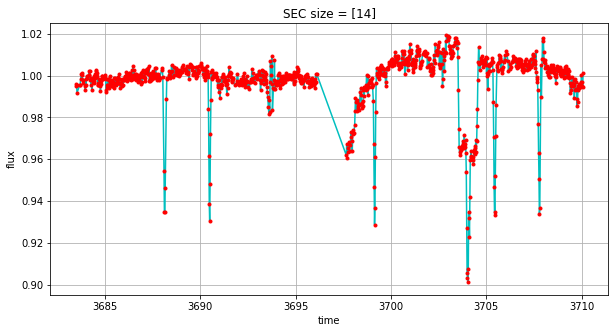

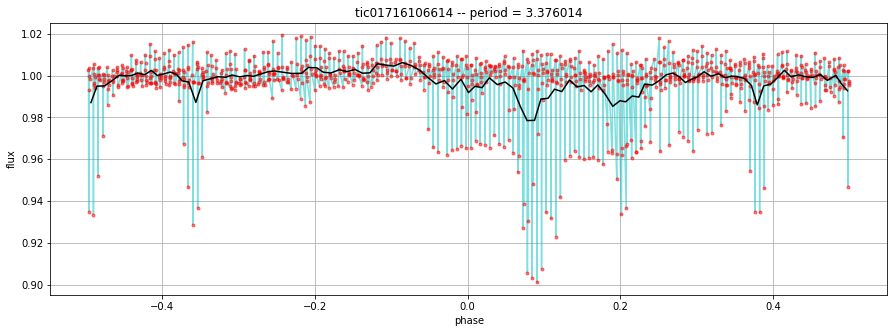

is that period able to record? ( or n)'


In [76]:
final_binary_p = []
for i in range(1108,len(final_binary)):
    clear_output()
    if final_binary[i][-28:-14] not in known_tic_name:
        p, ep, fe = hist_test(final_binary[i])
        print(final_binary[i],p, ep, fe)
        if p != 0:
            _,_,_ = mulit_light_curve(final_binary[i],norm=1,look=True)
            _ = sing_dc_func(final_binary[i],p,True)
            test_qun = input('is that period able to record? ('' or n)')
            while test_qun == 'd':
                d = np.float(input('give a divided number'))
                p = p/d
                _ = sing_dc_func(final_binary[i],p,True)
                test_qun = input('is that period able to record? ('' or n)')
            while test_qun == 'g':
                print(fit_peak(final_binary[i],look=True))
                p = np.float(input('give a period'))
                _ = sing_dc_func(final_binary[i],p,True)
                test_qun = input('is that period able to record? ('' or n)')
            if test_qun == '':
                final_binary_p.append([final_binary[i][-28:-14],p,ep,fe])

In [77]:
len(final_binary_p)

41

In [79]:
%run Binary_function.ipynb
base = "/Users/laote/sdsu/Research/binary/curve_bin/3w_binary/"
eci_time = dict()
period_v4 = []
for i in range(len(eci_time),len(final_binary_p)):
    if final_binary_p[i][1] == 0:
        period_v4.append([final_binary_p[i][0],final_binary_p[i][1],final_binary_p[i][2],final_binary_p[i][3]])
    else:
        dirname = base + final_binary_p[i][0] + '_SEC001_LC.txt'
        prim_eci,p,ep,fir_eci = check_eci(dirname,final_binary_p[i][1],final_binary_p[i][2],final_binary_p[i][3])
        eci_time[final_binary_p[i][0]] = prim_eci
        period_v4.append([final_binary_p[i][0],p,ep,fir_eci])
    print(i)
    _ = sing_dc_func(dirname,p,look=True)
    if i%20 == 0:
        clear_output()
np.save('eci_time',eci_time)

In [80]:
output_info(np.array(period_v4),'3wperiodv2')

for key in eci_time:
    if np.array(eci_time[key]).dtype == 'float64':
        f = open('./curve_bin/Binary_pe/%s.txt'%(key),'w')
        for ele in eci_time[key]: 
            f.write('%.5f\n'%(ele))
        f.close()